## GenomicSNP-Explorer: Variant Analysis in Maize

This notebook contains a **bioinformatics pipeline** for analyzing genomic variants in **drought-resistant vs. susceptible maize genotypes**.  
The workflow focuses on **SNP detection, genomic feature annotation, and comparative analysis** using publicly available data from **NCBI SRA and MaizeGDB**.  

### **Key Objectives**
- Download and preprocess raw sequencing data  
- Perform quality control and read alignment  
- Call and filter SNP variants  
- Annotate SNPs with gene regions and regulatory elements  
- Compare SNP distributions between resistant and susceptible maize genotypes  
- Generate summary statistics and visualizations  

### **Dataset Source:**
- **NCBI BioProject:** [PRJNA531553](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA531553)  
- **Data Provider:** Huazhong Agricultural University  
- **Total Accessions:** 519 samples (High-Quality Dataset)

### **Selected Maize Genotypes**
| Genotype | Drought Resistance | SRR Accession |
|----------|--------------------|--------------|
| YE478    | Resistant          | SRR8906861   |
| H21      | Susceptible        | SRR8906666   |

### **Reference Genome**
- **Species:** *Zea mays* (Maize)
- **Genome Build:** B73 (RefGen_v4)
- **Source:** MaizeGDB


### **Bioinformatics Pipeline Steps**
1. **Data Acquisition & Preprocessing**   
   - Download raw sequencing data from NCBI  
   - Perform quality control with **FastQC**  
   - Trim adapters and low-quality bases with **Trimmomatic**  

2. **Genome Alignment**  
   - Index reference genome using **BWA**  
   - Align reads to the genome using **BWA-MEM**  
   - Convert and sort alignment files with **SAMtools**  

3. **SNP Variant Calling**  
   - Call SNPs using **BCFtools**  
   - Filter variants based on quality scores  

4. **Genomic Feature Annotation**  
   - Identify SNP overlaps with gene regions using **BCFtools & BEDTools**  

5. **Comparative Analysis** 
   - Compare SNP distributions between genotypes  
   - Perform population genetics analysis with **VCFtools**  
   - Generate **visualizations & summary statistics**  

### **Output Files**
- **Filtered VCF Files**
- **SNP Annotation Tables**
- **SNP Distribution Plots**
- **Comparative Fst Analysis Reports**



#### Step 1: Download required files

#### Step 1.1: Download genome and annotation file

In [9]:
#Step 1.1: Download genome and annotation file

import requests
import gzip
import shutil
import os
import urllib3

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Set the output directory to your home directory
output_dir = os.path.join("genomic_downloads")
os.makedirs(output_dir, exist_ok=True)  # This should now work since it's under your home directory

# Download and decompress files with SSL verification disabled
def download_and_decompress(url, output_file):
    gz_file = os.path.join(output_dir, output_file + ".gz")
    final_file = os.path.join(output_dir, output_file)
    
    # Download file
    try:
        print(f"Downloading {gz_file}...")
        with requests.get(url, stream=True, verify=False) as response:
            response.raise_for_status()
            with open(gz_file, "wb") as f_out:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        f_out.write(chunk)
        print(f"Downloaded: {gz_file}")
    except Exception as e:
        print(f"Failed to download {gz_file}. Error: {e}")
        return

    # Decompress file
    try:
        print(f"Decompressing {gz_file}...")
        with gzip.open(gz_file, "rb") as f_in:
            with open(final_file, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Decompressed to: {final_file}")
    except Exception as e:
        print(f"Failed to decompress {gz_file}. Error: {e}")
        return
    finally:
        # Remove compressed file
        if os.path.exists(gz_file):
            os.remove(gz_file)
            print(f"Removed compressed file: {gz_file}")

# URLs for the files
urls = {
    "genome": "https://ftp.ensemblgenomes.ebi.ac.uk/pub/plants/release-60/fasta/zea_mays/dna/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa.gz",
    "annotation": "https://ftp.ensemblgenomes.ebi.ac.uk/pub/plants/release-60/gff3/zea_mays/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.60.chr.gff3.gz",
}

# File names
output_files = {
    "genome": "Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa",
    "annotation": "Zea_mays.Zm-B73-REFERENCE-NAM-5.0.60.chr.gff3",
}

# Download and decompress
for file_type, url in urls.items():
    download_and_decompress(url, output_files[file_type])

print(f"All files downloaded to: {output_dir}")

Downloaded: genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa.gz
Decompressing genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa.gz...
Decompressed to: genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa
Removed compressed file: genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa.gz
Downloaded: genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.60.chr.gff3.gz
Decompressing genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.60.chr.gff3.gz...
Decompressed to: genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.60.chr.gff3
Removed compressed file: genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.60.chr.gff3.gz
All files downloaded to: genomic_downloads


#### Step 1.2: Download fastq files of 2 genotypes using SRR number %

In [20]:
# Step 1.2 Download fastq files of 2 genotypes using SRR number
import os
import subprocess

# Define output directory for FASTQ files
fastq_dir = os.path.join("fastq_files")
os.makedirs(fastq_dir, exist_ok=True)  # Ensure the output directory exists

# Download FASTQ files using SRA Toolkit
def download_fastq(srr_id, fastq_dir):
    print(f"Downloading FASTQ files for {srr_id}...")
    # Use prefetch to download the SRA file
    subprocess.run(["prefetch", srr_id], check=True)
    
    # Use fasterq-dump to extract FASTQ files to the specified directory
    subprocess.run([
        "fasterq-dump", "--split-files", "--outdir", fastq_dir, srr_id
    ], check=True)
    
    # Compress the resulting FASTQ files
    for fq_file in os.listdir(fastq_dir):
        if fq_file.startswith(srr_id) and fq_file.endswith(".fastq"):
            fq_path = os.path.join(fastq_dir, fq_file)
            subprocess.run(["gzip", fq_path], check=True)
            print(f"Compressed: {fq_path}.gz")
    print(f"Downloaded and saved FASTQ files for {srr_id} to {fastq_dir}")

# List of SRR IDs
srr_ids = ["SRR8906861", "SRR8906666"]

# Download each SRR ID
for srr_id in srr_ids:
    download_fastq(srr_id, fastq_dir)

print(f"All FASTQ files are saved in: {fastq_dir}")

2025-01-04T17:37:39 prefetch.3.1.1: 1) Resolving 'SRR8906861'...
2025-01-04T17:37:41 prefetch.3.1.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-01-04T17:37:42 prefetch.3.1.1: 1) Downloading 'SRR8906861'...
2025-01-04T17:37:42 prefetch.3.1.1:  SRA Normalized Format file is being retrieved
2025-01-04T17:37:42 prefetch.3.1.1:  Downloading via HTTPS...
2025-01-04T17:50:33 prefetch.3.1.1:  HTTPS download succeed
2025-01-04T17:51:34 prefetch.3.1.1:  'SRR8906861' is valid: 14756992633 bytes were streamed from 14756987445
2025-01-04T17:51:34 prefetch.3.1.1: 1) 'SRR8906861' was downloaded successfully
2025-01-04T17:51:34 prefetch.3.1.1: 'SRR8906861' has 0 unresolved dependencies


spots read      : 150,839,494
reads read      : 301,678,988
reads written   : 301,678,988


Compressed: fastq_files/SRR8906861_1.fastq.gz
Compressed: fastq_files/SRR8906861_2.fastq.gz
Downloaded and saved FASTQ files for SRR8906861 to fastq_files
2025-01-04T20:28:52 prefetch.3.1.1: 1) Resolving 'SRR8906666'...
2025-01-04T20:28:54 prefetch.3.1.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-01-04T20:28:54 prefetch.3.1.1: 1) Downloading 'SRR8906666'...
2025-01-04T20:28:54 prefetch.3.1.1:  SRA Normalized Format file is being retrieved
2025-01-04T20:28:54 prefetch.3.1.1:  Downloading via HTTPS...
2025-01-04T20:49:01 prefetch.3.1.1:  HTTPS download succeed
2025-01-04T20:49:55 prefetch.3.1.1:  'SRR8906666' is valid: 13514480824 bytes were streamed from 13514467873
2025-01-04T20:49:55 prefetch.3.1.1: 1) 'SRR8906666' was downloaded successfully
2025-01-04T20:49:55 prefetch.3.1.1: 'SRR8906666' has 0 unresolved dependencies


spots read      : 131,462,470
reads read      : 262,924,940
reads written   : 262,924,940


Compressed: fastq_files/SRR8906666_1.fastq.gz
Compressed: fastq_files/SRR8906666_2.fastq.gz
Downloaded and saved FASTQ files for SRR8906666 to fastq_files
All FASTQ files are saved in: aligned_reads


#### Step 2: Run quality control on fastq files and trim reads

In [21]:

import os
import subprocess

def run_fastqc(fastq_file, output_dir):
    """Run quality control using FastQC."""
    print(f"Running FastQC on {fastq_file}...")
    subprocess.run(["fastqc", fastq_file, "--outdir", output_dir], check=True)
    print(f"FastQC complete for {fastq_file}. Reports saved in {output_dir}")

def trim_reads(fastq1, fastq2, output_fastq1, output_fastq2, adapter_file):
    """Trim low-quality reads and adapters using Trimmomatic."""
    if not os.path.exists(adapter_file):
        raise FileNotFoundError(f"Adapter file not found: {adapter_file}")
    print(f"Trimming reads: {fastq1} and {fastq2} using adapters from {adapter_file}")
    subprocess.run([
        "trimmomatic", "PE", "-threads", "8",
        fastq1, fastq2,  # Input files
        output_fastq1, "unpaired_1.fastq.gz",  # Paired and unpaired outputs
        output_fastq2, "unpaired_2.fastq.gz",
        f"ILLUMINACLIP:{adapter_file}:2:30:10", "LEADING:3", "TRAILING:3", "SLIDINGWINDOW:4:20", "MINLEN:50"
    ], check=True)
    print(f"Trimming complete. Trimmed files: {output_fastq1}, {output_fastq2}")

# Set up directories
fastqc_dir = os.path.expanduser("fastqc_reports")
os.makedirs(fastqc_dir, exist_ok=True)

trimmed_dir = os.path.expanduser("trimmed_fastq_files")
os.makedirs(trimmed_dir, exist_ok=True)

# Define adapter file path
adapter_file = "TruSeq3-PE.fa"

# Define input FASTQ files for each sample
samples = {
    "SRR8906861": ["fastq_files/SRR8906861_1.fastq.gz", "fastq_files/SRR8906861_2.fastq.gz"], # drought-resistant
    "SRR8906666": ["fastq_files/SRR8906666_1.fastq.gz", "fastq_files/SRR8906666_2.fastq.gz"] # drought-sensitive
}

# Perform QC and trimming for each sample
for sample, files in samples.items():
    fastq1, fastq2 = files

    # Run QC on raw reads
    run_fastqc(fastq1, fastqc_dir)
    run_fastqc(fastq2, fastqc_dir)

    # Prepare paths for trimmed outputs
    output_fastq1 = os.path.join(trimmed_dir, f"{sample}_1.trimmed.fastq.gz")
    output_fastq2 = os.path.join(trimmed_dir, f"{sample}_2.trimmed.fastq.gz")

    # Trim reads
    trim_reads(fastq1, fastq2, output_fastq1, output_fastq2, adapter_file)

    # Run QC on trimmed reads
    run_fastqc(output_fastq1, fastqc_dir)
    run_fastqc(output_fastq2, fastqc_dir)

print("Quality control and trimming complete for all samples.")

Running FastQC on fastq_files/SRR8906861_1.fastq.gz...
application/gzip


Started analysis of SRR8906861_1.fastq.gz
Approx 5% complete for SRR8906861_1.fastq.gz
Approx 10% complete for SRR8906861_1.fastq.gz
Approx 15% complete for SRR8906861_1.fastq.gz
Approx 20% complete for SRR8906861_1.fastq.gz
Approx 25% complete for SRR8906861_1.fastq.gz
Approx 30% complete for SRR8906861_1.fastq.gz
Approx 35% complete for SRR8906861_1.fastq.gz
Approx 40% complete for SRR8906861_1.fastq.gz
Approx 45% complete for SRR8906861_1.fastq.gz
Approx 50% complete for SRR8906861_1.fastq.gz
Approx 55% complete for SRR8906861_1.fastq.gz
Approx 60% complete for SRR8906861_1.fastq.gz
Approx 65% complete for SRR8906861_1.fastq.gz
Approx 70% complete for SRR8906861_1.fastq.gz
Approx 75% complete for SRR8906861_1.fastq.gz
Approx 80% complete for SRR8906861_1.fastq.gz
Approx 85% complete for SRR8906861_1.fastq.gz
Approx 90% complete for SRR8906861_1.fastq.gz
Approx 95% complete for SRR8906861_1.fastq.gz


Analysis complete for SRR8906861_1.fastq.gz
FastQC complete for fastq_files/SRR8906861_1.fastq.gz. Reports saved in fastqc_reports
Running FastQC on fastq_files/SRR8906861_2.fastq.gz...
application/gzip


Started analysis of SRR8906861_2.fastq.gz
Approx 5% complete for SRR8906861_2.fastq.gz
Approx 10% complete for SRR8906861_2.fastq.gz
Approx 15% complete for SRR8906861_2.fastq.gz
Approx 20% complete for SRR8906861_2.fastq.gz
Approx 25% complete for SRR8906861_2.fastq.gz
Approx 30% complete for SRR8906861_2.fastq.gz
Approx 35% complete for SRR8906861_2.fastq.gz
Approx 40% complete for SRR8906861_2.fastq.gz
Approx 45% complete for SRR8906861_2.fastq.gz
Approx 50% complete for SRR8906861_2.fastq.gz
Approx 55% complete for SRR8906861_2.fastq.gz
Approx 60% complete for SRR8906861_2.fastq.gz
Approx 65% complete for SRR8906861_2.fastq.gz
Approx 70% complete for SRR8906861_2.fastq.gz
Approx 75% complete for SRR8906861_2.fastq.gz
Approx 80% complete for SRR8906861_2.fastq.gz
Approx 85% complete for SRR8906861_2.fastq.gz
Approx 90% complete for SRR8906861_2.fastq.gz
Approx 95% complete for SRR8906861_2.fastq.gz


Analysis complete for SRR8906861_2.fastq.gz
FastQC complete for fastq_files/SRR8906861_2.fastq.gz. Reports saved in fastqc_reports
Trimming reads: fastq_files/SRR8906861_1.fastq.gz and fastq_files/SRR8906861_2.fastq.gz using adapters from TruSeq3-PE.fa


TrimmomaticPE: Started with arguments:
 -threads 8 fastq_files/SRR8906861_1.fastq.gz fastq_files/SRR8906861_2.fastq.gz trimmed_fastq_files/SRR8906861_1.trimmed.fastq.gz unpaired_1.fastq.gz trimmed_fastq_files/SRR8906861_2.trimmed.fastq.gz unpaired_2.fastq.gz ILLUMINACLIP:TruSeq3-PE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:20 MINLEN:50
Using PrefixPair: 'TACACTCTTTCCCTACACGACGCTCTTCCGATCT' and 'GTGACTGGAGTTCAGACGTGTGCTCTTCCGATCT'
ILLUMINACLIP: Using 1 prefix pairs, 0 forward/reverse sequences, 0 forward only sequences, 0 reverse only sequences
Quality encoding detected as phred33
Input Read Pairs: 150839494 Both Surviving: 150771566 (99.95%) Forward Only Surviving: 67928 (0.05%) Reverse Only Surviving: 0 (0.00%) Dropped: 0 (0.00%)
TrimmomaticPE: Completed successfully
Started analysis of SRR8906861_1.trimmed.fastq.gz


Trimming complete. Trimmed files: trimmed_fastq_files/SRR8906861_1.trimmed.fastq.gz, trimmed_fastq_files/SRR8906861_2.trimmed.fastq.gz
Running FastQC on trimmed_fastq_files/SRR8906861_1.trimmed.fastq.gz...
application/gzip


Approx 5% complete for SRR8906861_1.trimmed.fastq.gz
Approx 10% complete for SRR8906861_1.trimmed.fastq.gz
Approx 15% complete for SRR8906861_1.trimmed.fastq.gz
Approx 20% complete for SRR8906861_1.trimmed.fastq.gz
Approx 25% complete for SRR8906861_1.trimmed.fastq.gz
Approx 30% complete for SRR8906861_1.trimmed.fastq.gz
Approx 35% complete for SRR8906861_1.trimmed.fastq.gz
Approx 40% complete for SRR8906861_1.trimmed.fastq.gz
Approx 45% complete for SRR8906861_1.trimmed.fastq.gz
Approx 50% complete for SRR8906861_1.trimmed.fastq.gz
Approx 55% complete for SRR8906861_1.trimmed.fastq.gz
Approx 60% complete for SRR8906861_1.trimmed.fastq.gz
Approx 65% complete for SRR8906861_1.trimmed.fastq.gz
Approx 70% complete for SRR8906861_1.trimmed.fastq.gz
Approx 75% complete for SRR8906861_1.trimmed.fastq.gz
Approx 80% complete for SRR8906861_1.trimmed.fastq.gz
Approx 85% complete for SRR8906861_1.trimmed.fastq.gz
Approx 90% complete for SRR8906861_1.trimmed.fastq.gz
Approx 95% complete for SRR89

Analysis complete for SRR8906861_1.trimmed.fastq.gz
FastQC complete for trimmed_fastq_files/SRR8906861_1.trimmed.fastq.gz. Reports saved in fastqc_reports
Running FastQC on trimmed_fastq_files/SRR8906861_2.trimmed.fastq.gz...
application/gzip


Started analysis of SRR8906861_2.trimmed.fastq.gz
Approx 5% complete for SRR8906861_2.trimmed.fastq.gz
Approx 10% complete for SRR8906861_2.trimmed.fastq.gz
Approx 15% complete for SRR8906861_2.trimmed.fastq.gz
Approx 20% complete for SRR8906861_2.trimmed.fastq.gz
Approx 25% complete for SRR8906861_2.trimmed.fastq.gz
Approx 30% complete for SRR8906861_2.trimmed.fastq.gz
Approx 35% complete for SRR8906861_2.trimmed.fastq.gz
Approx 40% complete for SRR8906861_2.trimmed.fastq.gz
Approx 45% complete for SRR8906861_2.trimmed.fastq.gz
Approx 50% complete for SRR8906861_2.trimmed.fastq.gz
Approx 55% complete for SRR8906861_2.trimmed.fastq.gz
Approx 60% complete for SRR8906861_2.trimmed.fastq.gz
Approx 65% complete for SRR8906861_2.trimmed.fastq.gz
Approx 70% complete for SRR8906861_2.trimmed.fastq.gz
Approx 75% complete for SRR8906861_2.trimmed.fastq.gz
Approx 80% complete for SRR8906861_2.trimmed.fastq.gz
Approx 85% complete for SRR8906861_2.trimmed.fastq.gz
Approx 90% complete for SRR890686

Analysis complete for SRR8906861_2.trimmed.fastq.gz
FastQC complete for trimmed_fastq_files/SRR8906861_2.trimmed.fastq.gz. Reports saved in fastqc_reports
Running FastQC on fastq_files/SRR8906666_1.fastq.gz...
application/gzip


Started analysis of SRR8906666_1.fastq.gz
Approx 5% complete for SRR8906666_1.fastq.gz
Approx 10% complete for SRR8906666_1.fastq.gz
Approx 15% complete for SRR8906666_1.fastq.gz
Approx 20% complete for SRR8906666_1.fastq.gz
Approx 25% complete for SRR8906666_1.fastq.gz
Approx 30% complete for SRR8906666_1.fastq.gz
Approx 35% complete for SRR8906666_1.fastq.gz
Approx 40% complete for SRR8906666_1.fastq.gz
Approx 45% complete for SRR8906666_1.fastq.gz
Approx 50% complete for SRR8906666_1.fastq.gz
Approx 55% complete for SRR8906666_1.fastq.gz
Approx 60% complete for SRR8906666_1.fastq.gz
Approx 65% complete for SRR8906666_1.fastq.gz
Approx 70% complete for SRR8906666_1.fastq.gz
Approx 75% complete for SRR8906666_1.fastq.gz
Approx 80% complete for SRR8906666_1.fastq.gz
Approx 85% complete for SRR8906666_1.fastq.gz
Approx 90% complete for SRR8906666_1.fastq.gz
Approx 95% complete for SRR8906666_1.fastq.gz


Analysis complete for SRR8906666_1.fastq.gz
FastQC complete for fastq_files/SRR8906666_1.fastq.gz. Reports saved in fastqc_reports
Running FastQC on fastq_files/SRR8906666_2.fastq.gz...
application/gzip


Started analysis of SRR8906666_2.fastq.gz
Approx 5% complete for SRR8906666_2.fastq.gz
Approx 10% complete for SRR8906666_2.fastq.gz
Approx 15% complete for SRR8906666_2.fastq.gz
Approx 20% complete for SRR8906666_2.fastq.gz
Approx 25% complete for SRR8906666_2.fastq.gz
Approx 30% complete for SRR8906666_2.fastq.gz
Approx 35% complete for SRR8906666_2.fastq.gz
Approx 40% complete for SRR8906666_2.fastq.gz
Approx 45% complete for SRR8906666_2.fastq.gz
Approx 50% complete for SRR8906666_2.fastq.gz
Approx 55% complete for SRR8906666_2.fastq.gz
Approx 60% complete for SRR8906666_2.fastq.gz
Approx 65% complete for SRR8906666_2.fastq.gz
Approx 70% complete for SRR8906666_2.fastq.gz
Approx 75% complete for SRR8906666_2.fastq.gz
Approx 80% complete for SRR8906666_2.fastq.gz
Approx 85% complete for SRR8906666_2.fastq.gz
Approx 90% complete for SRR8906666_2.fastq.gz
Approx 95% complete for SRR8906666_2.fastq.gz


Analysis complete for SRR8906666_2.fastq.gz
FastQC complete for fastq_files/SRR8906666_2.fastq.gz. Reports saved in fastqc_reports
Trimming reads: fastq_files/SRR8906666_1.fastq.gz and fastq_files/SRR8906666_2.fastq.gz using adapters from TruSeq3-PE.fa


TrimmomaticPE: Started with arguments:
 -threads 8 fastq_files/SRR8906666_1.fastq.gz fastq_files/SRR8906666_2.fastq.gz trimmed_fastq_files/SRR8906666_1.trimmed.fastq.gz unpaired_1.fastq.gz trimmed_fastq_files/SRR8906666_2.trimmed.fastq.gz unpaired_2.fastq.gz ILLUMINACLIP:TruSeq3-PE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:20 MINLEN:50
Using PrefixPair: 'TACACTCTTTCCCTACACGACGCTCTTCCGATCT' and 'GTGACTGGAGTTCAGACGTGTGCTCTTCCGATCT'
ILLUMINACLIP: Using 1 prefix pairs, 0 forward/reverse sequences, 0 forward only sequences, 0 reverse only sequences
Quality encoding detected as phred33
Input Read Pairs: 131462470 Both Surviving: 131400483 (99.95%) Forward Only Surviving: 61987 (0.05%) Reverse Only Surviving: 0 (0.00%) Dropped: 0 (0.00%)
TrimmomaticPE: Completed successfully
Started analysis of SRR8906666_1.trimmed.fastq.gz


Trimming complete. Trimmed files: trimmed_fastq_files/SRR8906666_1.trimmed.fastq.gz, trimmed_fastq_files/SRR8906666_2.trimmed.fastq.gz
Running FastQC on trimmed_fastq_files/SRR8906666_1.trimmed.fastq.gz...
application/gzip


Approx 5% complete for SRR8906666_1.trimmed.fastq.gz
Approx 10% complete for SRR8906666_1.trimmed.fastq.gz
Approx 15% complete for SRR8906666_1.trimmed.fastq.gz
Approx 20% complete for SRR8906666_1.trimmed.fastq.gz
Approx 25% complete for SRR8906666_1.trimmed.fastq.gz
Approx 30% complete for SRR8906666_1.trimmed.fastq.gz
Approx 35% complete for SRR8906666_1.trimmed.fastq.gz
Approx 40% complete for SRR8906666_1.trimmed.fastq.gz
Approx 45% complete for SRR8906666_1.trimmed.fastq.gz
Approx 50% complete for SRR8906666_1.trimmed.fastq.gz
Approx 55% complete for SRR8906666_1.trimmed.fastq.gz
Approx 60% complete for SRR8906666_1.trimmed.fastq.gz
Approx 65% complete for SRR8906666_1.trimmed.fastq.gz
Approx 70% complete for SRR8906666_1.trimmed.fastq.gz
Approx 75% complete for SRR8906666_1.trimmed.fastq.gz
Approx 80% complete for SRR8906666_1.trimmed.fastq.gz
Approx 85% complete for SRR8906666_1.trimmed.fastq.gz
Approx 90% complete for SRR8906666_1.trimmed.fastq.gz
Approx 95% complete for SRR89

Analysis complete for SRR8906666_1.trimmed.fastq.gz
FastQC complete for trimmed_fastq_files/SRR8906666_1.trimmed.fastq.gz. Reports saved in fastqc_reports
Running FastQC on trimmed_fastq_files/SRR8906666_2.trimmed.fastq.gz...
application/gzip


Started analysis of SRR8906666_2.trimmed.fastq.gz
Approx 5% complete for SRR8906666_2.trimmed.fastq.gz
Approx 10% complete for SRR8906666_2.trimmed.fastq.gz
Approx 15% complete for SRR8906666_2.trimmed.fastq.gz
Approx 20% complete for SRR8906666_2.trimmed.fastq.gz
Approx 25% complete for SRR8906666_2.trimmed.fastq.gz
Approx 30% complete for SRR8906666_2.trimmed.fastq.gz
Approx 35% complete for SRR8906666_2.trimmed.fastq.gz
Approx 40% complete for SRR8906666_2.trimmed.fastq.gz
Approx 45% complete for SRR8906666_2.trimmed.fastq.gz
Approx 50% complete for SRR8906666_2.trimmed.fastq.gz
Approx 55% complete for SRR8906666_2.trimmed.fastq.gz
Approx 60% complete for SRR8906666_2.trimmed.fastq.gz
Approx 65% complete for SRR8906666_2.trimmed.fastq.gz
Approx 70% complete for SRR8906666_2.trimmed.fastq.gz
Approx 75% complete for SRR8906666_2.trimmed.fastq.gz
Approx 80% complete for SRR8906666_2.trimmed.fastq.gz
Approx 85% complete for SRR8906666_2.trimmed.fastq.gz
Approx 90% complete for SRR890666

Analysis complete for SRR8906666_2.trimmed.fastq.gz
FastQC complete for trimmed_fastq_files/SRR8906666_2.trimmed.fastq.gz. Reports saved in fastqc_reports
Quality control and trimming complete for all samples.


#### Step 3: Index the reference genome and align reads to the reference genome

##### 3.1 Index the reference genome

In [17]:
# Index the reference genome
def index_reference_genome(reference_genome):
    print(f"Indexing reference genome: {reference_genome}...")
    subprocess.run(["bwa", "index", reference_genome], check = True)
    print(f"Indexing complete for: {reference_genome}")
    
# Reference genome
reference_genome = "genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa"

# Index the reference genome
index_reference_genome(reference_genome)

Indexing reference genome: genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa...


[bwa_index] Pack FASTA... 6.32 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=4364151988, availableWord=319077676
[BWTIncConstructFromPacked] 10 iterations done. 99999988 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 199999988 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 299999988 characters processed.
[BWTIncConstructFromPacked] 40 iterations done. 399999988 characters processed.
[BWTIncConstructFromPacked] 50 iterations done. 499999988 characters processed.
[BWTIncConstructFromPacked] 60 iterations done. 599999988 characters processed.
[BWTIncConstructFromPacked] 70 iterations done. 699999988 characters processed.
[BWTIncConstructFromPacked] 80 iterations done. 799999988 characters processed.
[BWTIncConstructFromPacked] 90 iterations done. 899999988 characters processed.
[BWTIncConstructFromPacked] 100 iterations done. 999999988 characters processed.
[BWTIncConstructFromPacked] 110 iterations done. 1

Indexing complete for: genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa


508.71 sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa index genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa
[main] Real time: 1658.014 sec; CPU: 1603.193 sec


##### 3.2 Align reads to the reference genome

In [25]:
import os
import subprocess
    
# Step 2.2 Align reads to the reference genome
def align_reads(reference_genome, fastq1, fastq2, output_sam):
    print(f"Aligning reads: {fastq1} and {fastq2}...")
    subprocess.run([
        "bwa", "mem", "-t", "8", reference_genome, fastq1, fastq2, "-o", output_sam
    ], check=True)
    print(f"Alignment complete: {output_sam}")

# Reference genome
reference_genome = "genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa"

# Set up output directory for SAM files
output_dir = os.path.join('aligned_reads')
os.makedirs(output_dir, exist_ok = True) # Create directory if it does not exist
# Align each sample
samples = {
    "SRR8906861": ["trimmed_fastq_files/SRR8906861_1.trimmed.fastq.gz", "trimmed_fastq_files/SRR8906861_2.trimmed.fastq.gz", os.path.join(output_dir,"SRR8906861.sam"),],
    "SRR8906666": ["trimmed_fastq_files/SRR8906666_1.trimmed.fastq.gz", "trimmed_fastq_files/SRR8906666_2.trimmed.fastq.gz", os.path.join(output_dir, "SRR8906666.sam"),]
}

for sample, files in samples.items():
    align_reads(reference_genome, files[0], files[1], files[2])
    
print(f"Alignment complete. SAM files are saved in: {output_dir}")

Aligning reads: trimmed_fastq_files/SRR8906666_1.trimmed.fastq.gz and trimmed_fastq_files/SRR8906666_2.trimmed.fastq.gz...


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 543258 sequences (80000008 bp)...
[M::process] read 542960 sequences (80000188 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (48, 51509, 14, 37)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (126, 192, 308)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 672)
[M::mem_pestat] mean and std.dev: (204.58, 108.21)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 854)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (243, 298, 363)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (3, 603)
[M::mem_pestat] mean and std.dev: (304.98, 87.91)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 723)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percent

Alignment complete: aligned_reads/SRR8906666.sam
Alignment complete. SAM files are saved in: aligned_reads


[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem -t 8 -o aligned_reads/SRR8906666.sam genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa trimmed_fastq_files/SRR8906666_1.trimmed.fastq.gz trimmed_fastq_files/SRR8906666_2.trimmed.fastq.gz
[main] Real time: 26099.183 sec; CPU: 207675.052 sec


#### Step 4: Process SAM files to sorted BAM files

In [27]:
#import os
#import subprocess

# Convert SAM to BAM, sort, and index 
def process_bam(input_sam):
    output_bam = input_sam.replace(".sam", ".bam")
    sorted_bam = output_bam.replace(".bam", ".sorted.bam")
    print(f"Converting and sorting: {input_sam}...")
    subprocess.run(["samtools", "view", "-bS", input_sam, "-o", output_bam], check=True)
    subprocess.run(["samtools", "sort", output_bam, "-o", sorted_bam], check=True)
    subprocess.run(["samtools", "index", sorted_bam], check=True)
    print(f"Processed BAM: {sorted_bam}")
    return sorted_bam

samples = {
    "SRR8906861": ["trimmed_fastq_files/SRR8906861_1.trimmed.fastq.gz", "trimmed_fastq_files/SRR8906861_2.trimmed.fastq.gz", os.path.join(output_dir,"SRR8906861.sam"),],
    "SRR8906666": ["trimmed_fastq_files/SRR8906666_1.trimmed.fastq.gz", "trimmed_fastq_files/SRR8906666_2.trimmed.fastq.gz", os.path.join(output_dir, "SRR8906666.sam")]
}
# Process each sample
for sample, files in samples.items():
    sam_file = files [2] 
    process_bam(sam_file)

Converting and sorting: aligned_reads/SRR8906666.sam...


[bam_sort_core] merging from 28 files and 1 in-memory blocks...


Processed BAM: aligned_reads/SRR8906666.sorted.bam


#### Step 5: Call Variants to generate VCF files, compress and index it

##### 5.1 Call variants to generate VCF files
* Because of lack of space, I stored the temp file in D: and not in C: where the project is located

In [28]:
import os
import subprocess

# Function to call variants for an individual BAM file
def call_variants_individual(reference_genome, bam_file, output_vcf, temp_dir):
    print(f"Calling variants for BAM file: {bam_file}...")
    
    # Ensure the temporary directory exists
    os.makedirs(temp_dir, exist_ok=True)
    
    # Define the temporary BCF file path
    temp_bcf = os.path.join(temp_dir, os.path.basename(bam_file).replace(".bam", ".bcf"))
    
    # Step 1: Create a BCF file from the BAM
    subprocess.run([
        "bcftools", "mpileup", "-Ou", "-f", reference_genome, bam_file, "-o", temp_bcf
    ], check=True)
    print(f"Temporary BCF file saved at: {temp_bcf}")
    
    # Step 2: Call variants and generate the uncompressed VCF
    subprocess.run([
        "bcftools", "call", "-mv", "-Ov", "-o", output_vcf, temp_bcf
    ], check=True)
    print(f"Uncompressed VCF saved at: {output_vcf}")
    
    # Step 3: Cleanup temporary BCF file
    os.remove(temp_bcf)
    print(f"Temporary BCF file {temp_bcf} removed.")

# Define reference genome and paths
reference_genome = "genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.dna.toplevel.fa"
output_dir = "aligned_reads"  # Output directory for VCF files
temp_dir = "/mnt/d/temp_bcftools"  # Temporary directory on D drive

# BAM files to process
bam_files = [
    "aligned_reads/SRR8906861.sorted.bam",  # Resistant genotype
    "aligned_reads/SRR8906666.sorted.bam"   # Non-resistant genotype
]

# Call variants for each BAM file
vcf_files = []
for bam_file in bam_files:
    sample_name = os.path.basename(bam_file).replace(".sorted.bam", "")
    output_vcf = os.path.join(output_dir, f"{sample_name}.vcf")
    call_variants_individual(reference_genome, bam_file, output_vcf, temp_dir)
    vcf_files.append(output_vcf)

print(f"Variant calling completed. VCF files generated: {vcf_files}")

Calling variants for BAM file: aligned_reads/SRR8906861.sorted.bam...


[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250


Temporary BCF file saved at: /mnt/d/temp_bcftools/SRR8906861.sorted.bcf


Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid


Uncompressed VCF saved at: aligned_reads/SRR8906861.vcf
Temporary BCF file /mnt/d/temp_bcftools/SRR8906861.sorted.bcf removed.
Calling variants for BAM file: aligned_reads/SRR8906666.sorted.bam...


[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250


Temporary BCF file saved at: /mnt/d/temp_bcftools/SRR8906666.sorted.bcf


Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid


Uncompressed VCF saved at: aligned_reads/SRR8906666.vcf
Temporary BCF file /mnt/d/temp_bcftools/SRR8906666.sorted.bcf removed.
Variant calling completed. VCF files generated: ['aligned_reads/SRR8906861.vcf', 'aligned_reads/SRR8906666.vcf']


##### 5.2 Compress and index VCF files

In [18]:
import os
import subprocess

# Continue from Step 3: Compress the VCF file and index it using bgzip
def compress_and_index_vcf_bgzip(uncompressed_vcf):
    print(f"Continuing with compressing and indexing the VCF file: {uncompressed_vcf}...")
    
    # Step 3: Compress the VCF file using bgzip
    print(f"Compressing {uncompressed_vcf} using bgzip...")
    compressed_vcf = f"{uncompressed_vcf}.gz"
    subprocess.run(["bgzip", "-f", uncompressed_vcf], check=True)  # Compress the VCF
    print(f"Compressed VCF saved as: {compressed_vcf}")
    
    # Step 4: Index the compressed VCF file using tabix
    print(f"Indexing compressed VCF file: {compressed_vcf}...")
    subprocess.run(["tabix", "-p", "vcf", compressed_vcf], check=True)
    print(f"Compression and indexing completed. Compressed VCF: {compressed_vcf}")
    
    return compressed_vcf

compressed_vcfs = []
for vcf_file in vcf_files:
    compressed_vcf = compress_and_index_vcf_bgzip(vcf_file)
    compressed_vcfs.append(compressed_vcf)

Continuing with compressing and indexing the VCF file: aligned_reads/multi_sample.vcf/multi_sample.vcf...
Compressing aligned_reads/multi_sample.vcf/multi_sample.vcf using bgzip...
Compressed VCF saved as: aligned_reads/multi_sample.vcf/multi_sample.vcf.gz
Indexing compressed VCF file: aligned_reads/multi_sample.vcf/multi_sample.vcf.gz...
Compression and indexing completed. Compressed VCF: aligned_reads/multi_sample.vcf/multi_sample.vcf.gz


#### Step 6: Filter Variants

In [29]:
#(*) Filter variants
def filter_variants(input_vcf, output_vcf, min_qual=30, min_dp=10):
    print(f"Filtering variants in {input_vcf}...")
    subprocess.run([
        "bcftools", "filter",
        "-i", f"QUAL>{min_qual} && DP>{min_dp}",
        "-Oz", "-o", output_vcf,
        input_vcf
    ], check=True)
    print(f"Filtered VCF saved at: {output_vcf}")
    return output_vcf

filtered_vcfs = []
for compressed_vcf in compressed_vcfs:
    filtered_vcf = compressed_vcf.replace(".vcf.gz", ".filtered.vcf.gz")
    filter_variants(compressed_vcf, filtered_vcf)
    filtered_vcfs.append(filtered_vcf)

print(f"Filtering completed. Filtered VCF files: {filtered_vcfs}")

Filtering variants in aligned_reads/SRR8906861.vcf...
Filtered VCF saved at: aligned_reads/SRR8906861.filtered.vcf.gz
Filtering variants in aligned_reads/SRR8906666.vcf...
Filtered VCF saved at: aligned_reads/SRR8906666.filtered.vcf.gz
Filtering completed. Filtered VCF files: ['aligned_reads/SRR8906861.filtered.vcf.gz', 'aligned_reads/SRR8906666.filtered.vcf.gz']


#### Step 7: Identify unique variants

In [30]:
#(*) Identify unique variants
def index_vcf(vcf_file):
    """Index a compressed VCF file."""
    print(f"Indexing VCF file: {vcf_file}...")
    subprocess.run(["bcftools", "index", vcf_file], check=True)
    print(f"Index created for: {vcf_file}")

def extract_unique_variants(filtered_vcf1, filtered_vcf2, output_directory):
    """Extract unique variants from one VCF file compared to another."""
    print(f"Extracting unique variants from {filtered_vcf1} compared to {filtered_vcf2}...")
    subprocess.run(["mkdir", "-p", output_directory], check=True)
    subprocess.run([
        "bcftools", "isec",
        "-c", "none",  # Include sites unique to the first file
        "-p", output_directory,
        filtered_vcf1, filtered_vcf2
    ], check=True)
    print(f"Unique variants saved in directory: {output_directory}")

# File paths
filtered_vcfs = [
    "aligned_reads/SRR8906861.filtered.vcf.gz",
    "aligned_reads/SRR8906666.filtered.vcf.gz"
]
unique_resistant_dir = "aligned_reads/SRR8906861_unique"
unique_non_resistant_dir = "aligned_reads/SRR8906666_unique"

# Index VCF files
index_vcf(filtered_vcfs[0])
index_vcf(filtered_vcfs[1])

# Extract unique variants
extract_unique_variants(filtered_vcfs[0], filtered_vcfs[1], unique_resistant_dir)
extract_unique_variants(filtered_vcfs[1], filtered_vcfs[0], unique_non_resistant_dir)

print("Unique variant extraction completed.")

Indexing VCF file: aligned_reads/SRR8906861.filtered.vcf.gz...
Index created for: aligned_reads/SRR8906861.filtered.vcf.gz
Indexing VCF file: aligned_reads/SRR8906666.filtered.vcf.gz...
Index created for: aligned_reads/SRR8906666.filtered.vcf.gz
Extracting unique variants from aligned_reads/SRR8906861.filtered.vcf.gz compared to aligned_reads/SRR8906666.filtered.vcf.gz...


Unique variants saved in directory: aligned_reads/SRR8906861_unique
Extracting unique variants from aligned_reads/SRR8906666.filtered.vcf.gz compared to aligned_reads/SRR8906861.filtered.vcf.gz...
Unique variants saved in directory: aligned_reads/SRR8906666_unique
Unique variant extraction completed.


#### Step 8: Generate annotation files (.tsv file from .gff3), sort, compress and index it

In [31]:
#(*)
#Step 8.1: Convert .gff3 to a vlaid TSV with a header

import pandas as pd

def gff3_to_valid_tsv_with_header(gff3_file, output_tsv, header_file):
    print(f"Converting {gff3_file} to a valid TSV: {output_tsv} and generating header: {header_file}...")

    with open(gff3_file, 'r') as gff3:
        rows = []
        for line in gff3:
            if line.startswith("#"):
                continue  # Skip comments
            fields = line.strip().split('\t')
            chrom, source, feature, start, end, score, strand, phase, attributes = fields
            # Extract attributes
            info = {k: v for k, v in [attr.split('=') for attr in attributes.split(';')]}
            rows.append([chrom, start, end, info.get('ID', '.'), info.get('Name', '.')])

    # Save TSV without a header row
    df = pd.DataFrame(rows, columns=['CHROM', 'POS', 'END', 'ID', 'NAME'])
    df.to_csv(output_tsv, sep='\t', index=False, header=False)  # No column headers

    # Save the header separately for bcftools
    with open(header_file, 'w') as header:
        header.write("##INFO=<ID=ID,Number=1,Type=String,Description=\"Annotation ID\">\n")
        header.write("##INFO=<ID=NAME,Number=1,Type=String,Description=\"Gene Name\">\n")

    print(f"Generated TSV: {output_tsv} and header: {header_file}")

# File paths
gff3_file = "genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.60.chr.gff3"
output_tsv = "genomic_downloads/annotation_file.tsv"
header_file = "genomic_downloads/annotation_file.header"

# Convert GFF3 to a valid TSV and generate the header

gff3_to_valid_tsv_with_header(gff3_file, output_tsv, header_file)



Converting genomic_downloads/Zea_mays.Zm-B73-REFERENCE-NAM-5.0.60.chr.gff3 to a valid TSV: genomic_downloads/annotation_file.tsv and generating header: genomic_downloads/annotation_file.header...
Generated TSV: genomic_downloads/annotation_file.tsv and header: genomic_downloads/annotation_file.header


In [32]:
# 8.2: Sort, compress and index annotation file
def sort_annotation_file(annotation_file, sorted_file):
    """Sort the annotation file by CHROM, POS, and END."""
    print(f"Sorting annotation file: {annotation_file}...")
    df = pd.read_csv(annotation_file, sep='\t', header=None, names=['CHROM', 'POS', 'END', 'ID', 'NAME'])
    df['POS'] = df['POS'].astype(int)  # Ensure POS and END are integers
    df['END'] = df['END'].astype(int)
    sorted_df = df.sort_values(by=['CHROM', 'POS', 'END'])
    sorted_df.to_csv(sorted_file, sep='\t', index=False, header=False)
    print(f"Sorted annotation file saved at: {sorted_file}")

def compress_and_index_annotation_file(annotation_file, compressed_file):
    """Compress and index an annotation file."""
    print(f"Compressing annotation file: {annotation_file}...")
    subprocess.run(["bgzip", annotation_file, "-c"], stdout=open(compressed_file, "wb"), check=True)
    print(f"Compressed file saved at: {compressed_file}")

    print(f"Indexing annotation file: {compressed_file}...")
    subprocess.run(["tabix", "-s", "1", "-b", "2", "-e", "3", compressed_file], check=True)
    print(f"Index created for: {compressed_file}")

# File paths
annotation_file = "genomic_downloads/annotation_file.tsv"
sorted_annotation_file = "genomic_downloads/annotation_file.sorted.tsv"
compressed_annotation_file = "genomic_downloads/annotation_file.tsv.gz"

# Sort, compress, and index the annotation file
sort_annotation_file(annotation_file, sorted_annotation_file)
compress_and_index_annotation_file(sorted_annotation_file, compressed_annotation_file)

Sorting annotation file: genomic_downloads/annotation_file.tsv...
Sorted annotation file saved at: genomic_downloads/annotation_file.sorted.tsv
Compressing annotation file: genomic_downloads/annotation_file.sorted.tsv...
Compressed file saved at: genomic_downloads/annotation_file.tsv.gz
Indexing annotation file: genomic_downloads/annotation_file.tsv.gz...
Index created for: genomic_downloads/annotation_file.tsv.gz


#### Step 9: Annotate unique variants

In [ ]:
# (*) Annotate unique variants

def annotate_variants(input_vcf, compressed_annotation_file, output_annotated_vcf, header_file):
    """Annotate variants in the VCF file."""
    print(f"Annotating variants in {input_vcf}...")
    subprocess.run([
        "bcftools", "annotate",
        "-a", compressed_annotation_file,
        "-h", header_file,
        "-c", "CHROM,POS,INFO/ID,INFO/NAME",
        "-Oz", "-o", output_annotated_vcf,
        input_vcf
    ], check=True)
    print(f"Annotated VCF saved at: {output_annotated_vcf}")
    return output_annotated_vcf

# File paths
unique_resistant_vcf = "aligned_reads/SRR8906861_unique/0000.vcf"
unique_non_resistant_vcf = "aligned_reads/SRR8906666_unique/0000.vcf"
annotated_resistant_vcf = "aligned_reads/SRR8906861.unique.annotated.vcf.gz"
annotated_non_resistant_vcf = "aligned_reads/SRR8906666.unique.annotated.vcf.gz"

# Step 2: Annotate variants
annotate_variants(unique_resistant_vcf, compressed_annotation_file, annotated_resistant_vcf, header_file)
annotate_variants(unique_non_resistant_vcf, compressed_annotation_file, annotated_non_resistant_vcf, header_file)

Annotating variants in aligned_reads/SRR8906861_unique/0000.vcf...


Annotated VCF saved at: aligned_reads/SRR8906861.unique.annotated.vcf.gz
Annotating variants in aligned_reads/SRR8906666_unique/0000.vcf...


#### Step 10: Summarize and Visualize data on variant types, chromosome distributions, and potential functional impacts

##### Step 10.1 Summarize data 

In [6]:
import subprocess 
# Step 1: Extract Summary Using bcftools

# 1.1 Summarize variant types
def summarize_variant_types(input_vcf, output_stats):
    print(f"Summarizing variant types for {input_vcf}...")
    with open(output_stats, "w") as stats_file:
        subprocess.run(["bcftools", "stats", input_vcf], stdout=stats_file, check=True)
    print(f"Summary statistics saved to {output_stats}")

# 1.2 Extract counts of variant types
def extract_variant_counts(stats_file, output_summary):
    print(f"Extracting variant counts from {stats_file}...")
    with open(output_summary, "w") as summary_file:
        subprocess.run(["grep", "SN", stats_file], stdout=summary_file, check=True)
    print(f"Variant summary saved to {output_summary}")

# 1.3 Extract chromosomes counts
def extract_chromosome_counts(input_vcf, output_counts):
    print(f"Extracting chromosome counts from {input_vcf}...")
    with open(output_counts, "w") as counts_file:
        query_process = subprocess.Popen(["bcftools", "query", "-f", "%CHROM\n", input_vcf], stdout=subprocess.PIPE)
        sort_process = subprocess.Popen(["sort"], stdin=query_process.stdout, stdout=subprocess.PIPE)
        uniq_process = subprocess.Popen(["uniq", "-c"], stdin=sort_process.stdout, stdout=counts_file)
        query_process.stdout.close()  # Allow query_process to receive a SIGPIPE if sort exits
        sort_process.stdout.close()  # Allow sort_process to receive a SIGPIPE if uniq exits
        uniq_process.wait()  # Wait for the final process to complete
    print(f"Chromosome counts saved to {output_counts}")

# 1.4 Extract functional impact
def extract_functional_impact(input_vcf, output_impact):
    print(f"Extracting functional impact from {input_vcf}...")
    query_process = subprocess.Popen(
        ["bcftools", "query", "-f", "%INFO/NAME\n", input_vcf], stdout=subprocess.PIPE
    )
    sort_process = subprocess.Popen(["sort"], stdin=query_process.stdout, stdout=subprocess.PIPE)
    uniq_process = subprocess.Popen(["uniq", "-c"], stdin=sort_process.stdout, stdout=subprocess.PIPE)
    
    query_process.stdout.close()  # Allow query_process to receive a SIGPIPE if sort exits
    sort_process.stdout.close()  # Allow sort_process to receive a SIGPIPE if uniq exits
    
    with open(output_impact, "w") as impact_file:
        for line in uniq_process.stdout:
            impact_file.write(line.decode("utf-8"))  # Write each line of output directly to the file
    
    uniq_process.stdout.close()  # Ensure we close the final pipe explicitly
    print(f"Functional impact saved to {output_impact}")

# Paths to input VCF files
resistant_vcf = "aligned_reads/SRR8906861.unique.annotated.vcf.gz"
non_resistant_vcf = "aligned_reads/SRR8906666.unique.annotated.vcf.gz"

# Paths to output files
resistant_stats = "bcftools_output/stats/resistant_stats.txt"
non_resistant_stats = "bcftools_output/stats/non_resistant_stats.txt"
resistant_variant_summary = "bcftools_output/variant_summary/resistant_variant_summary.txt"
non_resistant_variant_summary = "bcftools_output/variant_summary/non_resistant_variant_summary.txt"
resistant_chromosome_counts = "bcftools_output/chromosome_counts/resistant_chromosome_counts.txt"
non_resistant_chromosome_counts = "bcftools_output/chromosome_counts/non_resistant_chromosome_counts.txt"
resistant_functional_impact = "bcftools_output/functional_impact/resistant_functional_impact.txt"
non_resistant_functional_impact = "bcftools_output/functional_impact/non_resistant_functional_impact.txt"

# Execute commands
summarize_variant_types(resistant_vcf, resistant_stats)
summarize_variant_types(non_resistant_vcf, non_resistant_stats)

extract_variant_counts(resistant_stats, resistant_variant_summary)
extract_variant_counts(non_resistant_stats, non_resistant_variant_summary)

extract_chromosome_counts(resistant_vcf, resistant_chromosome_counts)
extract_chromosome_counts(non_resistant_vcf, non_resistant_chromosome_counts)

extract_functional_impact(resistant_vcf, resistant_functional_impact)
extract_functional_impact(non_resistant_vcf, non_resistant_functional_impact)

Summarizing variant types for aligned_reads/SRR8906861.unique.annotated.vcf.gz...
Summary statistics saved to resistant_stats.txt
Summarizing variant types for aligned_reads/SRR8906666.unique.annotated.vcf.gz...
Summary statistics saved to non_resistant_stats.txt
Extracting variant counts from resistant_stats.txt...
Variant summary saved to resistant_variant_summary.txt
Extracting variant counts from non_resistant_stats.txt...
Variant summary saved to non_resistant_variant_summary.txt
Extracting chromosome counts from aligned_reads/SRR8906861.unique.annotated.vcf.gz...
Chromosome counts saved to resistant_chromosome_counts.txt
Extracting chromosome counts from aligned_reads/SRR8906666.unique.annotated.vcf.gz...
Chromosome counts saved to non_resistant_chromosome_counts.txt
Extracting functional impact from aligned_reads/SRR8906861.unique.annotated.vcf.gz...
Functional impact saved to resistant_functional_impact.txt
Extracting functional impact from aligned_reads/SRR8906666.unique.annot

##### Step 10.2: Load Data 

In [2]:
# Import libraries and load data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load variant summary data
# Function to load and clean variant summary data
def load_variant_summary(file_path):
    try:
        # Read the file, skipping the commented lines
        df = pd.read_csv(
            file_path,
            sep="\t",
            comment="#",  # Ignore lines starting with '#'
            header=None,  # No header row in the file
            engine="python",  # Use Python engine to handle varying field lengths
            names=["Type", "ID", "Key", "Value"],  # Assign column names
        )
        # Filter to retain only rows with relevant data (where Type is 'SN')
        df_filtered = df[df["Type"] == "SN"].copy()
        # Convert the 'Value' column to numeric where applicable
        df_filtered["Value"] = pd.to_numeric(df_filtered["Value"], errors="coerce")
        return df_filtered
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None
# Save the DataFrame to a file
def save_dataframe_to_file(df, output_file):
    try:
        df.to_csv(output_file, index=False, sep="\t")  # Save as tab-separated file
        print(f"DataFrame successfully saved to {output_file}")
    except Exception as e:
        print(f"Error saving DataFrame to {output_file}: {e}")
        
# Load the data for resistant and non-resistant variants
resistant_variant = load_variant_summary("bcftools_output/variant_summary/resistant_variant_summary.txt")
non_resistant_variant = load_variant_summary("bcftools_output/variant_summary/non_resistant_variant_summary.txt")

# Display the resulting DataFrame for verification
if resistant_variant is not None:
    print(resistant_variant)
if non_resistant_variant is not None:
    print(non_resistant_variant)

# Save the processed data to files
if resistant_variant is not None:
    save_dataframe_to_file(resistant_variant, "processed_data/resistant_variant_summary_processed.txt")
    print(resistant_variant)

if non_resistant_variant is not None:
    save_dataframe_to_file(non_resistant_variant, "processed_data/non_resistant_variant_summary_processed.txt")
    print(non_resistant_variant)

  Type  ID                                Key    Value
0   SN   0                 number of samples:        1
1   SN   0                 number of records:  5844680
2   SN   0                 number of no-ALTs:        0
3   SN   0                    number of SNPs:  5480957
4   SN   0                    number of MNPs:        0
5   SN   0                  number of indels:   363723
6   SN   0                  number of others:        0
7   SN   0      number of multiallelic sites:    18018
8   SN   0  number of multiallelic SNP sites:    14983
  Type  ID                                Key    Value
0   SN   0                 number of samples:        1
1   SN   0                 number of records:  7877560
2   SN   0                 number of no-ALTs:        0
3   SN   0                    number of SNPs:  7387325
4   SN   0                    number of MNPs:        0
5   SN   0                  number of indels:   490235
6   SN   0                  number of others:        0
7   SN   0

In [ ]:
# Load chromosome data
resistant_chromosome = pd.read_csv("bcftools_output/chromosome_counts/resistant_chromosome_counts.txt", sep="\s+", header=None, names=["Count", "Chromosome"])
non_resistant_chromosome = pd.read_csv("bcftools_output/chromosome_counts/non_resistant_chromosome_counts.txt", sep="\s+", header=None, names=["Count", "Chromosome"])

# Filter to include only rows where Chromosome does not contain "scaf_"
resistant_chromosome = resistant_chromosome[~resistant_chromosome["Chromosome"].str.contains("scaf_")]
non_resistant_chromosome = non_resistant_chromosome[~non_resistant_chromosome["Chromosome"].str.contains("scaf_")]

# Add group labels for comparison
resistant_chromosome["Group"] = "Resistant"
non_resistant_chromosome["Group"] = "Non-Resistant"

# Combine data
chromosome_data = pd.concat([resistant_chromosome, non_resistant_chromosome])
# Save the dataframe to a file
chromosome_data.to_csv("processed_data/chromosome_only.txt", index=False, sep="\t")  # Save as tab-separated file

In [ ]:
# Load functional impact data
resistant_impact = pd.read_csv("bcftools_output/functional_impact/resistant_functional_impact.txt", sep="\s+", header=None, names=["Count", "Impact"])
non_resistant_impact = pd.read_csv("bcftools_output/functional_impact/non_resistant_functional_impact.txt", sep="\s+", header=None, names=["Count", "Impact"])

##### 10. 3 Visualize data on variant types, chromosome distributions, and potential functional impacts

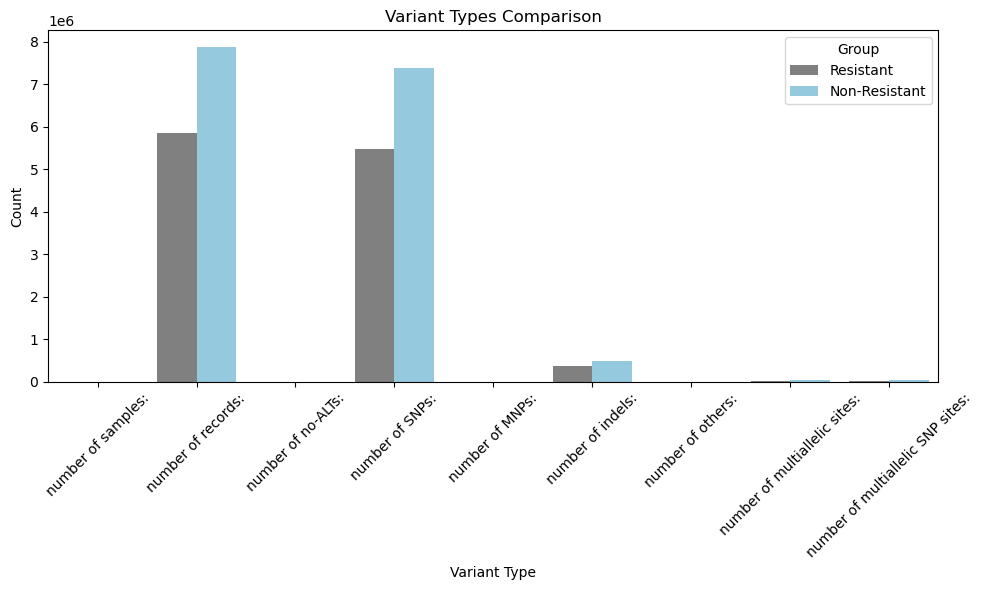

In [18]:
# Plot 1: Variant types comparison
# Add group labels for comparison
resistant_variant["Group"] = "Resistant"
non_resistant_variant["Group"] = "Non-Resistant"
variant_data = pd.concat([resistant_variant, non_resistant_variant])

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=variant_data, x="Key", y="Value", hue="Group", palette=["grey", "skyblue"])
plt.title("Variant Types Comparison")
plt.xlabel("Variant Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()

output_path = "figures/variant_types_comparison.png"
plt.savefig(output_path, dpi = 300)
print(f"Figure saved at {output_path}")

# Display the plot
plt.show()

##### This bar plot compares the counts of various types of variants (SNPs, indels) between resistant and non-resistant genotypes.
* The number of variant entries is higher in non-resistant genotype than in resistant genotype.
* The counts for SNPs dominate the dataset, significantly exceeding other variant types for both groups.
* Indels and other variant types (e.g., MNPs and multiallelic sites) are present in much smaller numbers.

The higher counts for non-resistant genotypes suggest differences in mutation profiles, but the dataset limited scope (single genotype per group) prevents generalization.

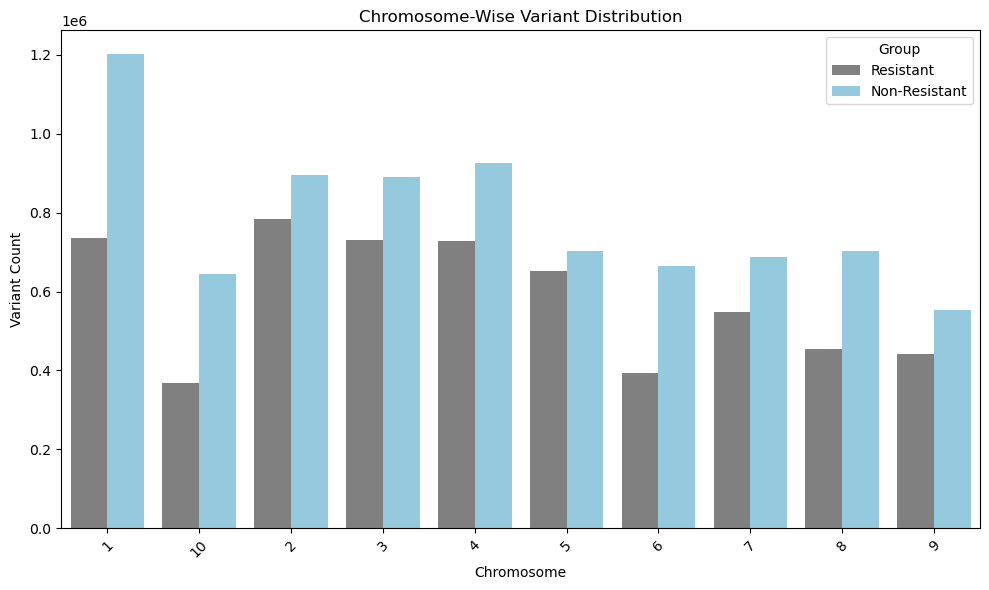

In [14]:
# plot 2: Chromosome-wise variant distribution

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=chromosome_data, x="Chromosome", y="Count", hue="Group", palette=["grey", "skyblue"])
plt.title("Chromosome-Wise Variant Distribution")
plt.xlabel("Chromosome")
plt.ylabel("Variant Count")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
output_path = "figures/chromosome_wise_variant_distribution.png"
plt.savefig(output_path, dpi = 300)
print(f"Figure saved at {output_path}")

# Display the plot
plt.show()

#####  This plot highlights the distribution of variants across chromosomes for both resistant and non-resistant genotypes.
* Chromosome 1 has the highest variant count in the non-resistant genotype.
* The resistant genotype shows a relatively even distribution of variants across chromosomes compared to the non-resistant group.
* Chromosome 10 has the lowest variant count in both groups, reflecting a shared characteristic.

Chromosome-specific patterns of variation could be biologically relevant but require replication in more genotypes to confirm.


In [ ]:
# Load functional impact data
resistant_impact = pd.read_csv("resistant_functional_impact.txt", sep="\s+", header=None, names=["Count", "Impact"])
non_resistant_impact = pd.read_csv("non_resistant_functional_impact.txt", sep="\s+", header=None, names=["Count", "Impact"])

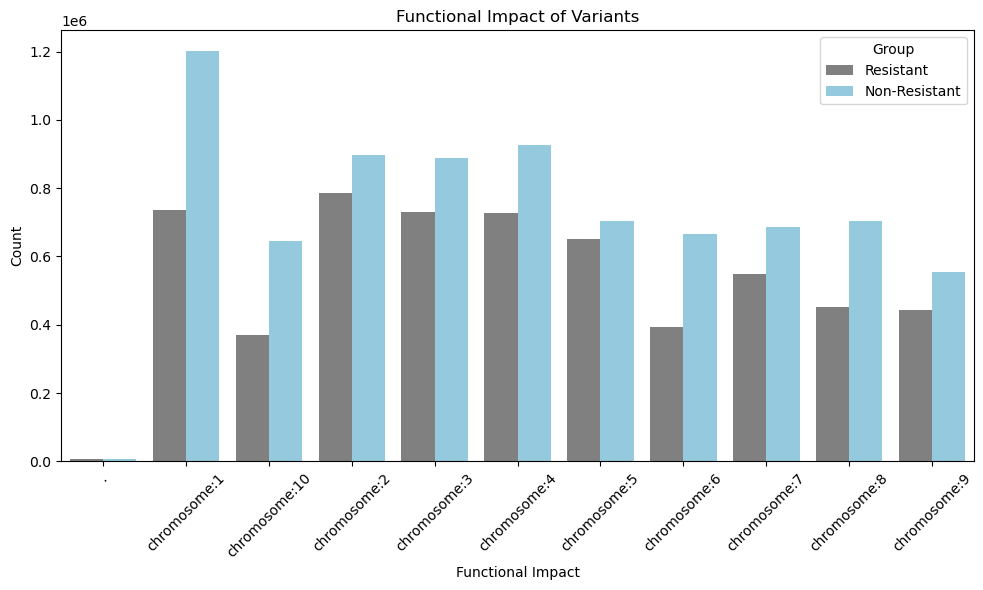

In [17]:
# Plot 3: Functional impact comparison
# Add group labels for comparison
resistant_impact["Group"] = "Resistant"
non_resistant_impact["Group"] = "Non-Resistant"
impact_data = pd.concat([resistant_impact, non_resistant_impact])

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=impact_data, x="Impact", y="Count", hue="Group", palette=["grey", "skyblue"])
plt.title("Functional Impact of Variants")
plt.xlabel("Functional Impact")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
output_path = "figures/functional_impact_of_variants.png"
plt.savefig(output_path, dpi = 300)
print(f"Figure saved at {output_path}")

# Display the plot
plt.show()

##### This plot seems to compare the counts of variants classified by functional impact, such as whether they occur in specific genomic regions or genes.
* Non-resistant genotypes consistently show higher counts across all functional categories.
* Chromosome 1 shows a particularly high count, aligning with its dominance in the previous plot.
* The relatively consistent pattern across other chromosomes suggests that non-resistance is associated with a higher overall mutational load.

While interesting, the functional implications of these differences are unclear without additional data. Further exploration is needed to link specific mutations to phenotypic traits.


### Step: Visualize Genomic Differences 
Generate visualizations to compare SNPs and genes between resistant and non-resistant genotypes.

In [ ]:

# Load SNP data for visualization
resistant_snps = resistant_vcf['POS']
non_resistant_snps = non_resistant_vcf['POS']

# Plot SNP distribution
plt.figure(figsize=(10, 6))
plt.hist(resistant_snps, bins=100, alpha=0.5, label='Resistant')
plt.hist(non_resistant_snps, bins=100, alpha=0.5, label='Non-Resistant')
plt.title('SNP Distribution')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.legend()
plt.show()
